### Obtained Perplexity: -17.13 Coherence: 0.38, Best Number of Topics= 60

In [1]:
#Basic Libraries
import re
import numpy as np
import pandas as pd
from pprint import pprint
import sys
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
# spacy for lemmatization
import spacy
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [3]:
#Load Dataset
df=pd.read_csv('/home/smriti/Desktop/NLP/MITACS/Anxiety/Data/CSV/Reddit/rAnxiety14.csv')
#getting rid of NaN
df=df.replace(np.nan, '', regex=True)
#getting rid of deleted values
df['Text']=df['Text'].replace('[deleted]','')
#Combining title and text
df["Post"] = df["Title"] + df["Text"]
#Now that we don't need Title or Text, we drop those columns before saving the file
df=df.drop(['Title', 'Text'], axis = 1)

/home/smriti/.local/lib/python3.5/site-packages/pandas/core/computation/check.py:17: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


In [4]:
df=df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [5]:
df.head()

,Number of Comments,Date Posted,Post
0,66,2014-12-26 00:39:39 EST-0500,How I feel drinking coffee during a panic attack
1,111,2014-12-24 19:16:42 EST-0500,Merry X-mas to us loners.Many of us who suffer...
2,74,2014-12-22 16:24:53 EST-0500,Does anybody here suffers from always feel gui...
3,18,2014-12-25 14:16:04 EST-0500,"Hey you (yes, you!)Whatever today holds, I hop..."
4,55,2014-12-28 13:57:32 EST-0500,[RANT] I always feel like everyone secretly ha...


In [6]:
# Convert to list
data=df.Post.values.tolist()
# Remove new line characters
data=[re.sub('\s+', ' ', sent) for sent in data]
# Remove distracting single quotes
data=[re.sub("\'", "", sent) for sent in data]

In [7]:
#Function to clean up text
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) 

In [8]:
#Clean up text
data_words=list(sent_to_words(data))
print(data_words[:1])

[['how', 'feel', 'drinking', 'coffee', 'during', 'panic', 'attack']]


In [9]:
# Build the bigram and trigram models
bigram=gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram=gensim.models.Phrases(bigram[data_words], threshold=100)

In [10]:
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod=gensim.models.phrases.Phraser(bigram)
trigram_mod=gensim.models.phrases.Phraser(trigram)

In [11]:
# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['how', 'feel', 'drinking', 'coffee', 'during', 'panic_attack']


In [12]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]


In [13]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [27]:
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(data_lemmatized[:1])

# Create Dictionary needed for topic modelling
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=60,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

[['feel', 'drink', 'coffee']]


In [28]:
# Print the Keyword in the topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(44,
  '0.000*"circus" + 0.000*"waist" + 0.000*"battery" + 0.000*"appearance" + '
  '0.000*"warped" + 0.000*"strangeness" + 0.000*"scatter" + 0.000*"odd" + '
  '0.000*"distorted" + 0.000*"demente"'),
 (35,
  '0.000*"circus" + 0.000*"waist" + 0.000*"battery" + 0.000*"appearance" + '
  '0.000*"warped" + 0.000*"strangeness" + 0.000*"scatter" + 0.000*"odd" + '
  '0.000*"distorted" + 0.000*"demente"'),
 (2,
  '0.000*"circus" + 0.000*"waist" + 0.000*"battery" + 0.000*"appearance" + '
  '0.000*"warped" + 0.000*"strangeness" + 0.000*"scatter" + 0.000*"odd" + '
  '0.000*"distorted" + 0.000*"demente"'),
 (11,
  '0.000*"circus" + 0.000*"waist" + 0.000*"battery" + 0.000*"appearance" + '
  '0.000*"warped" + 0.000*"strangeness" + 0.000*"scatter" + 0.000*"odd" + '
  '0.000*"distorted" + 0.000*"demente"'),
 (39,
  '0.000*"circus" + 0.000*"waist" + 0.000*"battery" + 0.000*"appearance" + '
  '0.000*"warped" + 0.000*"strangeness" + 0.000*"scatter" + 0.000*"odd" + '
  '0.000*"distorted" + 0.000*"demente"

In [29]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.


Perplexity:  -17.13593795846216


In [30]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.3861782080953099


In [31]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df=pd.DataFrame()
    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row=row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row=sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j==0:  # => dominant topic
                wp=ldamodel.show_topic(topic_num)
                topic_keywords=", ".join([word for word, prop in wp])
                sent_topics_df=sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns=['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
     # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [32]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_lemmatized)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,7.0,0.3269,"feel, be, anxiety, really, make, want, know, h...","[feel, drink, coffee]"
1,1,4.0,0.3892,"anxiety, remember, try, see, year, thing, look...","[loner, many, suffer, anxiety, depression, cel..."
2,2,7.0,0.3455,"feel, be, anxiety, really, make, want, know, h...","[suffer, always, feel, guilty]"
3,3,7.0,0.3637,"feel, be, anxiety, really, make, want, know, h...","[today, hold, hope, find, peace, smile, deserv..."
4,4,7.0,0.3514,"feel, be, anxiety, really, make, want, know, h...","[rant, always, feel, secretly, hate, be, sick,..."


In [33]:
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,7.0,0.3269,"feel, be, anxiety, really, make, want, know, h...","[feel, drink, coffee]"
1,1,4.0,0.3892,"anxiety, remember, try, see, year, thing, look...","[loner, many, suffer, anxiety, depression, cel..."
2,2,7.0,0.3455,"feel, be, anxiety, really, make, want, know, h...","[suffer, always, feel, guilty]"
3,3,7.0,0.3637,"feel, be, anxiety, really, make, want, know, h...","[today, hold, hope, find, peace, smile, deserv..."
4,4,7.0,0.3514,"feel, be, anxiety, really, make, want, know, h...","[rant, always, feel, secretly, hate, be, sick,..."
5,5,4.0,0.2649,"anxiety, remember, try, see, year, thing, look...","[stop, stare, phone, go, take, shower, long, p..."
6,6,7.0,0.2666,"feel, be, anxiety, really, make, want, know, h...","[mother, understand, daughter, depress, daught..."
7,7,4.0,0.3007,"anxiety, remember, try, see, year, thing, look...","[experience, increase, anxiety, pmse, be, depr..."
8,8,7.0,0.3839,"feel, be, anxiety, really, make, want, know, h...","[help, year, can, sit, anymore, cry, help, help]"
9,9,7.0,0.3155,"feel, be, anxiety, really, make, want, know, h...","[suffer, scopophobia, fear, look, have, suffer..."


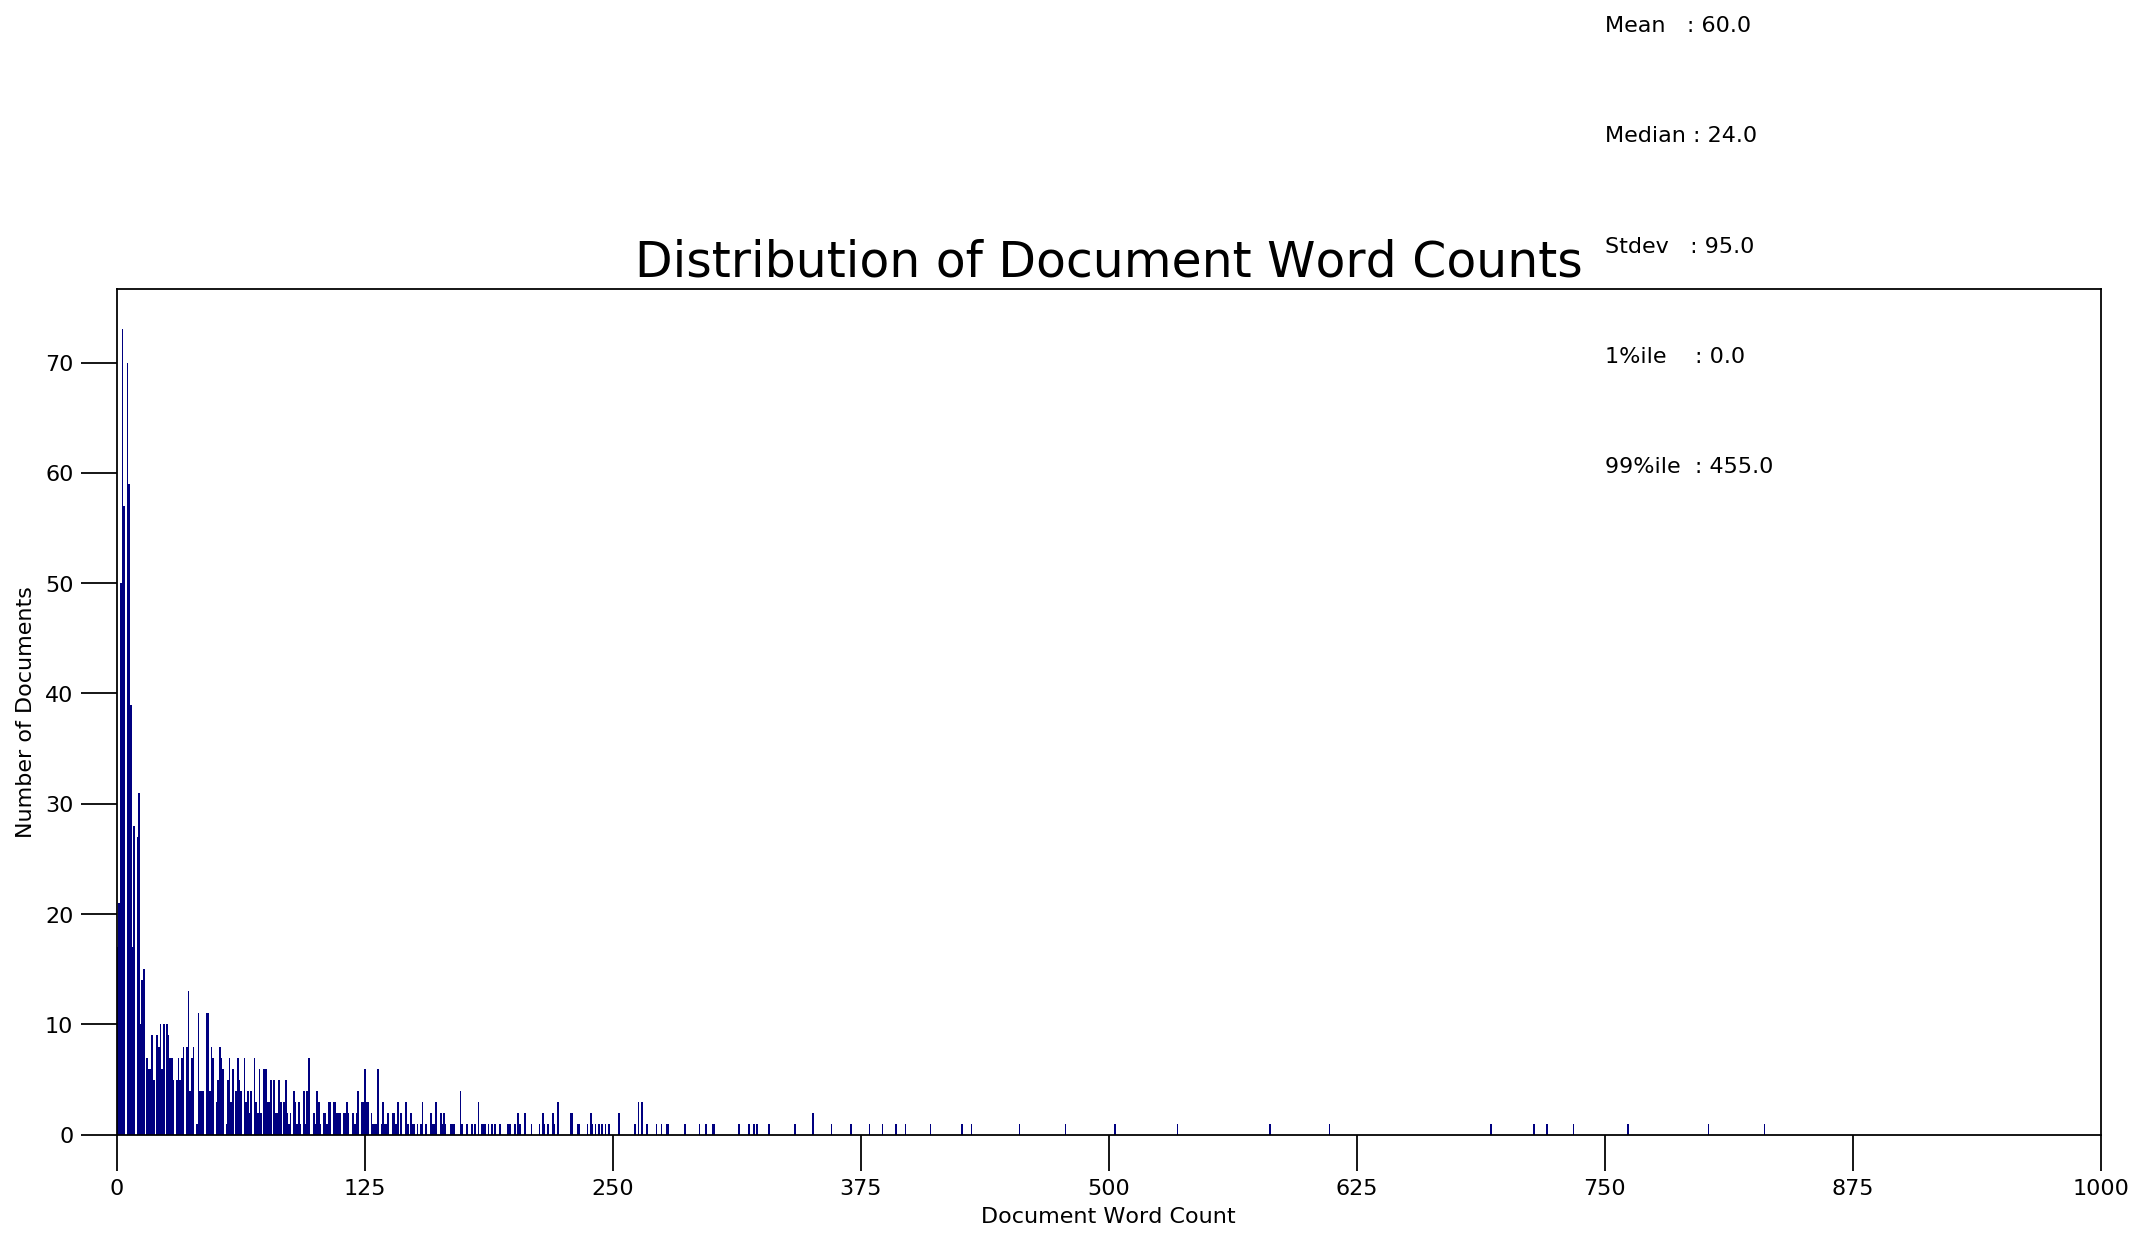

In [34]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

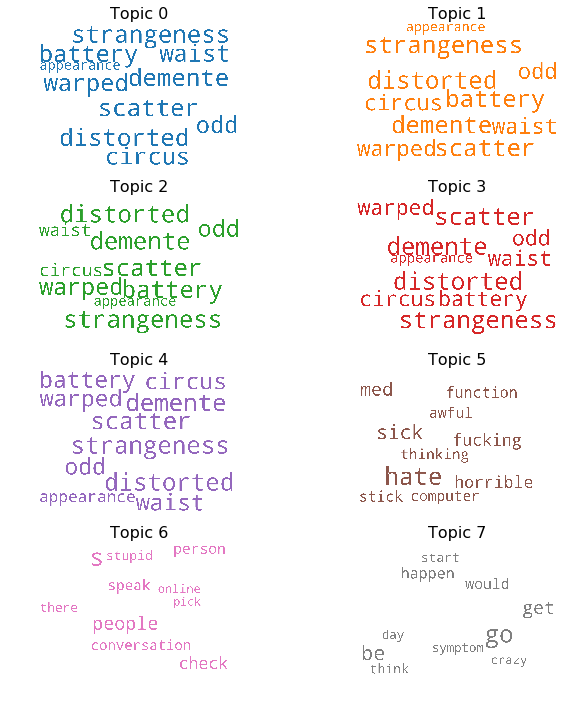

In [35]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(4, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [36]:
df_dominant_topic.to_csv("Reddit2014.csv")

In [24]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(alpha='auto', corpus=corpus, num_topics=20, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [25]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=100, step=6)

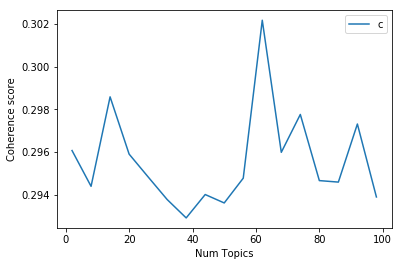

In [26]:
# Show graph
limit=100; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')